In [4]:
import copy
from core.datasets import FaceEmotionsDataset
from core.transform import Resize, RandomCrop, ToTensor
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, models
%matplotlib inline

In [5]:
class_names = [
    "neutral",
    "happiness",
    "surprise",
    "sadness",
    "anger",
    "disgust",
    "fear",
    "contempt",
]

In [6]:
data_transforms = transforms.Compose([
    Resize(68),
    RandomCrop(64),
    ToTensor()
])

In [7]:
dataset = FaceEmotionsDataset(
    csv_file="data/csv/balanced.csv",
    root_dir="data/img/",
    classes=class_names,
    transform=data_transforms,
)

In [8]:
shuffle_dataset = True
random_seed = 0
# Creating data indices for training and validation splits
dataset_size = len(dataset)
indexes = list(range(dataset_size))
split = int(np.floor(0.3 * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indexes)

index_splits = {
    'train': indexes[split:],
    'val': indexes[:split],
}

# Creating PyTorch data samplers and loaders
samplers = {
    x: SubsetRandomSampler(index_splits[x])
    for x in ['train', 'val']
}

In [9]:
dataloaders = {
    x: DataLoader(
        dataset,
        batch_size=4,
        sampler=samplers[x],
        num_workers=4,
    )
    for x in ['train', 'val']
}

In [10]:
dataset_sizes = {
    x: len(index_splits[x])
    for x in ['train', 'val']
}

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


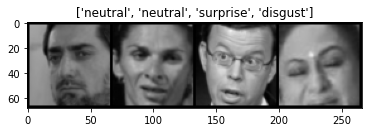

In [13]:
# Get batch of training data
data = next(iter(dataloaders['train']))
inputs, classes = data["image"], data["emotion"]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data['image'], data['emotion']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.double())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloaders['val']):
            inputs, labels = data['image'], data['emotion']
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.double())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = model_ft.double()
model_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=25
)

In [ ]:
visualize_model(model_ft)